In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = [10, 5]


In [2]:
def calStability(raw, task_order, method, normalise=False, raw_acc=False, _offline=False):
    values = {k:[] for k in method}

    for t in task_order:
        rows = raw[raw["task_order"]==t]
        offline = rows[rows["method"]=="offline"]
        
        for m in method:                
            target = rows[rows["method"]==m]
            _m = target[target["task_index"]==1][["accuracy", "no_of_test", "no_of_correct_prediction"]]
            
            if m=="offline":
                if _offline:
                    if raw_acc:
                        val = list(_m["accuracy"])
                    else:
                        val = float((_m["accuracy"]).mean())

                    values[m].append(val)
                continue
                
            if normalise:    
                _ideal = offline[offline["task_index"]==1]["accuracy"]
                
                val = float((_m["accuracy"]/float(_ideal)).sum()/len(_m))
                values[m].append(val)
                
            elif raw_acc:
                val = (_m["accuracy"])
                values[m].append(list(val))
                
            else:
                val = float((_m["accuracy"]).sum()/len(_m))
                    
                values[m].append(val)
    
    return values

In [3]:
def calPlasticity(raw, task_order, method, normalise=False, raw_acc=False, _offline=False):
    values = {k:[] for k in method}

    for t in task_order:
        rows = raw[raw["task_order"]==t]
        offline = rows[rows["method"]=="offline"]
        
        for m in method:
            _sum = 0.0
            if raw_acc:
                _sum = []
                
            target = rows[rows["method"]==m]
            train_session = target["train_session"].unique()
            
            if m=="offline":
                if _offline:
                    if raw_acc:
                        val = list(target[target["train_session"]==target["task_index"]]["accuracy"])
                    else:
                        val = target[target["train_session"]==target["task_index"]]["accuracy"].mean()

                    values[m].append(val)
                continue
    
            target["train_session"] = pd.to_numeric(target["train_session"], errors='coerce')
            _m = target[target["train_session"]==(target["task_index"])][["accuracy", "no_of_test", "no_of_correct_prediction"]]
            
            if normalise:    
                _ideal = offline["accuracy"]
                val = _m["accuracy"].div(_ideal.values, axis=0).sum()/len(_m)
                values[m].append(val)
                
            elif raw_acc:
                val = (_m["accuracy"])
                values[m].append(list(val))
            else:
                val = float((_m["accuracy"]).sum()/len(_m))    
                values[m].append(val)
                
            
    
    return values

In [4]:
def calOverallAcc(raw, task_order, method, normalise=False, raw_acc=False):
    values = {k:[] for k in method}

    for t in task_order:
        rows = raw[raw["task_order"]==t]
        offline = rows[rows["method"]=="offline"]
        
        for m in method:
            if m=="offline":
                continue
                    
            _sum = 0.0
            if raw_acc:
                _sum = []
                
            target = rows[rows["method"]==m]
            
            task_index = target["task_index"].unique()
            train_session = target["train_session"].unique()
            _m = target[target["train_session"]==str(len(task_index))]
            for t in task_index:
                t = int(t)
                _m1 = _m[_m["task_index"]==t]["accuracy"]
                assert len(_m1)==1

                if normalise:
                    _ideal = offline[offline["task_index"]==t]["accuracy"]
                    _sum += float(_m1)/float(_ideal)
                    
                elif raw_acc:
                    _sum.append(float(_m1))
                    
                else:
                    _sum += float(_m1)

            if raw_acc:
                values[m].append(_sum)
                continue
                
                
            if len(train_session)==0:
                values[m].append(np.nan)
            else:
                val = _sum/len(train_session)
                values[m].append(val)
    
    return values

In [5]:
# Overall accuracy at each step
def calOverallAccEach(raw, task_order, method, normalise=False, raw_acc=False, _offline=False):
    values = {k:[] for k in method}

    for t in task_order:
        rows = raw[raw["task_order"]==t]
        offline = rows[rows["method"]=="offline"]
        
        for m in method:
            if m=="offline" and (not _offline):
                continue
                    
            _sum = 0.0
            if raw_acc:
                _sum = []
                
            target = rows[rows["method"]==m]
            
            task_index = target["task_index"].unique()
            train_session = target["train_session"].unique()
            target["train_session"] = pd.to_numeric(target["train_session"], errors='coerce')
            
            val = []
            for s in train_session:
                s = int(s)
                
                _m = target[target["train_session"]==(s)]
                _sum = _m["accuracy"].sum()/len(_m)
                val.append(_sum)
                
            values[m].append(val)
                
    return values

In [6]:
all_values = {}
for d in ["HouseA", "CASAS", "PAMAP", "DSADS"]:
    dataset = d
    folder = "../../Results/"+dataset+"/exp_no_of_hidden/"
    _folder = "../../Results/"+dataset+"/exp_offline_acc/"
    
    raw = pd.read_csv(folder+"results.txt")
    _raw = pd.read_csv(_folder+"results.txt")
    raw.columns = [c.strip() for c in raw.columns]
    _raw.columns = [c.strip() for c in raw.columns]

    cmd = raw["cmd"].unique()
    task_order = raw["task_order"].unique()
    method = raw["method"].unique()

    stability = []
    plasticity = []
    overallAcc = []
    print(d, "Working")
    for c in cmd:
        print("CMD", c)
        target = raw[raw["cmd"]==c]
        _target = _raw[_raw["cmd"]==0]
        m = calStability(target, task_order, method, raw_acc=True)
        m2 = calStability(_target, task_order, method, raw_acc=True, _offline=True)
        m["offline"] = m2["offline"]
        stability.append(m)
        
        m = calPlasticity(target, task_order, method, raw_acc=True)
        m2 = calPlasticity(_target, task_order, method, raw_acc=True, _offline=True)
        m["offline"] = m2["offline"]
        plasticity.append(m)
        
        m = calOverallAccEach(target, task_order, method, raw_acc=True)
        m2 = calOverallAccEach(_target, task_order, method, raw_acc=True, _offline=True)
        m["offline"] = m2["offline"]
        overallAcc.append(m)
    print(d, "DONE")
    all_values[d] = (stability, plasticity, overallAcc)

HouseA Working
CMD 0
CMD 1
CMD 2
CMD 3
HouseA DONE
CASAS Working
CMD 0
CMD 1
CMD 2
CMD 3
CASAS DONE
PAMAP Working
CMD 0
CMD 1
CMD 2
CMD 3
PAMAP DONE
DSADS Working
CMD 0
CMD 1
CMD 2
CMD 3
DSADS DONE


In [7]:
_all_values = {}
for d in ["HouseA", "DSADS"]:
    dataset = d
    folder = "../../Results/"+dataset+"/exp_mgan_5000/"
    
    raw = pd.read_csv(folder+"results.txt")
    raw.columns = [c.strip() for c in raw.columns]

    cmd = raw["cmd"].unique()
    task_order = raw["task_order"].unique()
    method = raw["method"].unique()

    stability = []
    plasticity = []
    overallAcc = []
    print(d, "Working")
    for c in cmd:
        print("CMD", c)
        target = raw[raw["cmd"]==c]
        m = calStability(target, task_order, method, raw_acc=True)
        stability.append(m)
        
        m = calPlasticity(target, task_order, method, raw_acc=True)
        plasticity.append(m)
        
        m = calOverallAccEach(target, task_order, method, raw_acc=True)
        overallAcc.append(m)
    print(d, "DONE")
    _all_values[d] = (stability, plasticity, overallAcc)

HouseA Working
CMD 3
HouseA DONE
DSADS Working
CMD 3
DSADS DONE


# Continual learning 

In [8]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

def plotline(values, label, x=[], models=None, legends=None):
    plt.rcParams['figure.figsize'] = [10, 5]
    plt.rcParams.update({'font.size': 20})
    
    m = [] 
    merr = []
    if models is None:
        models = ["mp-gan", "mp-wgan", "sg-cgan", "sg-cwgan"]

    if legends is None:
        legends = models
        
    numbers = []
    for model in models:
        nTaskOrder = len(values[model])
        nTask = len(values[model][0])
        
        _pivot = [[] for i in range(nTask)]
        for i in range(nTaskOrder):
            for j in range(nTask):
                _pivot[j].append(values[model][i][j])
        
        avg = [(np.nanmean(v), stats.sem(v, nan_policy="omit")) for v in _pivot]
        numbers.append(avg)

    fig, ax = plt.subplots()
    
    patterns = [ "-s" , "-o" , "-x" , "-D" , "-+" , "-*", "-2" ]
    for i, model in enumerate(models):
        mval = [v for (v, _) in numbers[i]]
        merr = [e for (_, e) in numbers[i]]
        print(x, model, mval)
        ax.errorbar(x, mval, yerr=merr, fmt=patterns[i])

        mx = [v+e for (v, e) in numbers[i]]
        mn = [v-e for (v, e) in numbers[i]]
        
#         ax.fill_between(x, mn, mx, alpha=0.2)

    ax.set_ylim(ymin=-0.1, ymax=1.1)
    ax.set_title(label)
    ax.set_xticks(x)
    ax.set_xticklabels(x)
    ax.legend(legends, prop={'size': 20}, loc=3, bbox_to_anchor=(1, 0.4))
#     ax.legend(prop={'size': 20}, bbox_to_anchor=(1.05, 1), loc=0, borderaxespad=0.)


    fig.tight_layout()

    plt.show()

In [9]:
import copy

# select the best model (best GAN and best hidden units) => "sg-cgan" with highest number of neuron
def selectModel(db, model, cmd, mgan5000=False):
    (stability, plasticity, overallAcc) = copy.deepcopy(all_values[db])
    
    if mgan5000:
        (_stability, _plasticity, _overallAcc) = _all_values[db]
        stability[cmd][model] = _stability[0][model]
        plasticity[cmd][model] = _plasticity[0][model]
        overallAcc[cmd][model] = _overallAcc[0][model]
    
        
    models = [model, "exact", "none", "offline", "batch"]
    legends = ["HAR-GAN", "Exact Reply", "None", "Offline", "Batch"]
    
    x = [1,2,3,4,5]
    if db=="HouseA":
        x = [1,2,3]
    
    stability[cmd]["batch"] = []
    plasticity[cmd]["batch"] = []
    overallAcc[cmd]["batch"] = []
    for i in range(len(stability[cmd]["offline"])):
        
        v = overallAcc[cmd]["offline"][i]
        stability[cmd]["batch"].append([v[-1] for i in v])
        plasticity[cmd]["batch"].append([v[-1] for i in v])
        overallAcc[cmd]["batch"].append([v[-1] for i in v])
        
        
    plotline(stability[cmd], "Stability of the model", x=x, models=models, legends=legends)
    plotline(plasticity[cmd], "Plasticity of the model", x=x, models=models, legends=legends)
    plotline(overallAcc[cmd], "Overall performance", x=x, models=models, legends=legends)

In [10]:
# print(all_values["HouseA"][0][3]["mp-wgan"])
# print("====")
# print(_all_values["HouseA"][0][0]["mp-wgan"])

cGAN 5000
[1, 2, 3] sg-cgan [0.9904761904761905, 0.8582565284178185, 0.8208007852362691]
[1, 2, 3] exact [0.9904761904761905, 0.9479070660522273, 0.9053984456403812]
[1, 2, 3] none [0.9904761904761905, 0.0, 0.0]
[1, 2, 3] offline [0.9904761904761905, 0.9501920122887864, 0.9064220188413736]
[1, 2, 3] batch [0.8734564022554847, 0.8734564022554847, 0.8734564022554847]


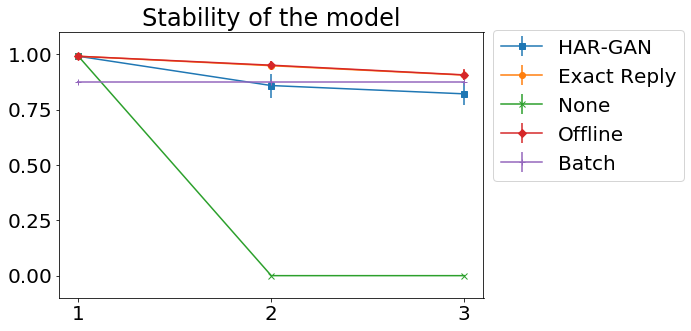

[1, 2, 3] sg-cgan [0.9904761904761905, 0.9236272117808622, 0.7700596827584509]
[1, 2, 3] exact [0.9904761904761905, 0.9286319410640294, 0.8868996457671818]
[1, 2, 3] none [0.9904761904761905, 0.9747727272727273, 0.9907446808510638]
[1, 2, 3] offline [0.9904761904761905, 0.9147857872178756, 0.8631234714604472]
[1, 2, 3] batch [0.8734564022554847, 0.8734564022554847, 0.8734564022554847]


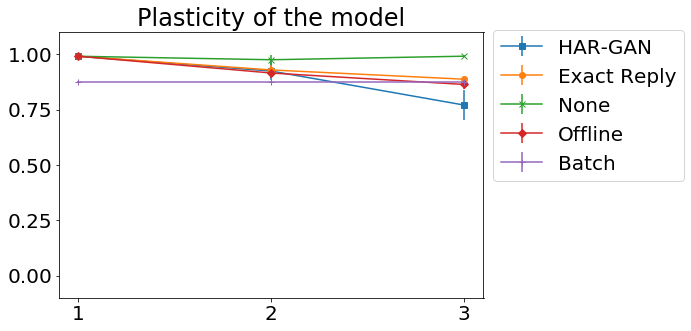

[1, 2, 3] sg-cgan [0.9904761904761905, 0.8909418700993404, 0.7810491639832751]
[1, 2, 3] exact [0.9904761904761905, 0.9382695035581283, 0.8825882061241306]
[1, 2, 3] none [0.9904761904761905, 0.4873863636363637, 0.33287980589772304]
[1, 2, 3] offline [0.9904761904761905, 0.932488899753331, 0.8734564022554847]
[1, 2, 3] batch [0.8734564022554847, 0.8734564022554847, 0.8734564022554847]


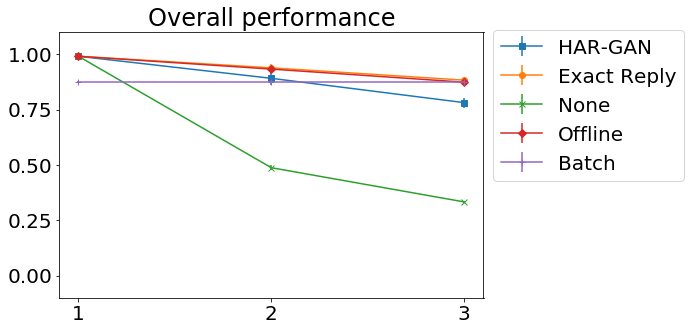

mGAN 5000
[1, 2, 3] mp-wgan [0.9904761904761905, 0.8984447004608296, 0.8825800006445167]
[1, 2, 3] exact [0.9904761904761905, 0.9479070660522273, 0.9053984456403812]
[1, 2, 3] none [0.9904761904761905, 0.0, 0.0]
[1, 2, 3] offline [0.9904761904761905, 0.9501920122887864, 0.9064220188413736]
[1, 2, 3] batch [0.8734564022554847, 0.8734564022554847, 0.8734564022554847]


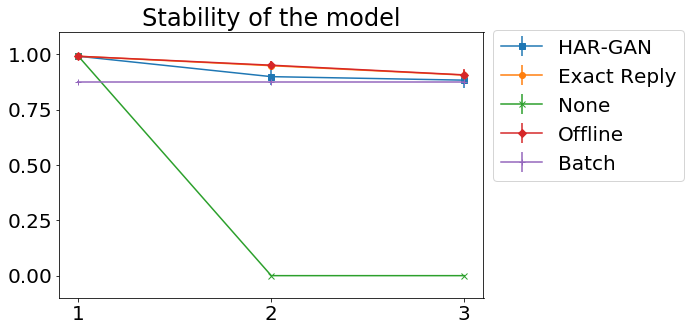

[1, 2, 3] mp-wgan [0.9904761904761905, 0.9188719670256174, 0.7760967234489794]
[1, 2, 3] exact [0.9904761904761905, 0.9286319410640294, 0.8868996457671818]
[1, 2, 3] none [0.9904761904761905, 0.9747727272727273, 0.9907446808510638]
[1, 2, 3] offline [0.9904761904761905, 0.9147857872178756, 0.8631234714604472]
[1, 2, 3] batch [0.8734564022554847, 0.8734564022554847, 0.8734564022554847]


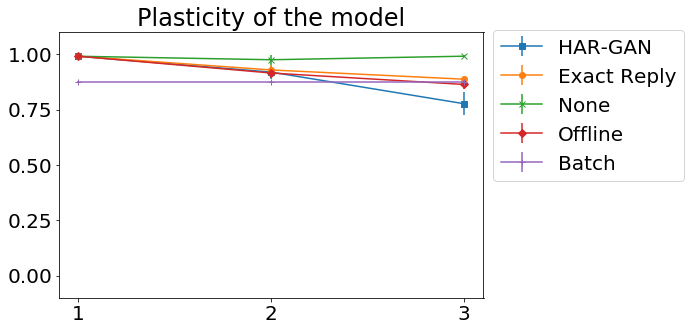

[1, 2, 3] mp-wgan [0.9904761904761905, 0.9086583337432235, 0.8417282803490945]
[1, 2, 3] exact [0.9904761904761905, 0.9382695035581283, 0.8825882061241306]
[1, 2, 3] none [0.9904761904761905, 0.4873863636363637, 0.33287980589772304]
[1, 2, 3] offline [0.9904761904761905, 0.932488899753331, 0.8734564022554847]
[1, 2, 3] batch [0.8734564022554847, 0.8734564022554847, 0.8734564022554847]


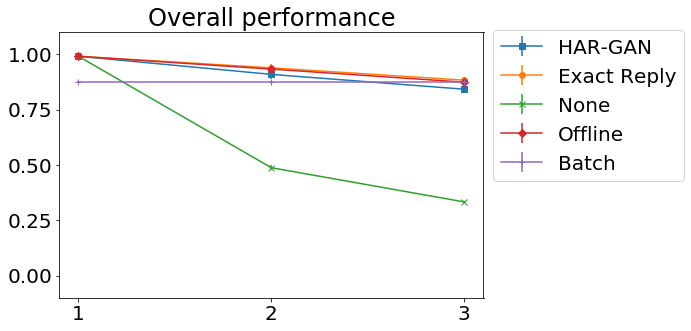

mGAN 1000
[1, 2, 3] mp-wgan [0.9904761904761905, 0.7504608294930876, 0.6753677236741753]
[1, 2, 3] exact [0.9904761904761905, 0.9479070660522273, 0.9053984456403812]
[1, 2, 3] none [0.9904761904761905, 0.0, 0.0]
[1, 2, 3] offline [0.9904761904761905, 0.9501920122887864, 0.9064220188413736]
[1, 2, 3] batch [0.8734564022554847, 0.8734564022554847, 0.8734564022554847]


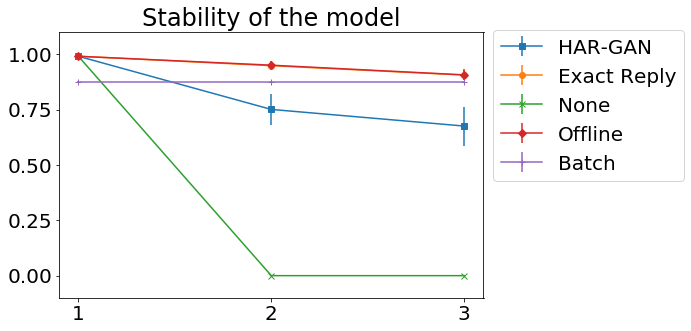

[1, 2, 3] mp-wgan [0.9904761904761905, 0.9467941297525337, 0.7805034635318564]
[1, 2, 3] exact [0.9904761904761905, 0.9286319410640294, 0.8868996457671818]
[1, 2, 3] none [0.9904761904761905, 0.9747727272727273, 0.9907446808510638]
[1, 2, 3] offline [0.9904761904761905, 0.9147857872178756, 0.8631234714604472]
[1, 2, 3] batch [0.8734564022554847, 0.8734564022554847, 0.8734564022554847]


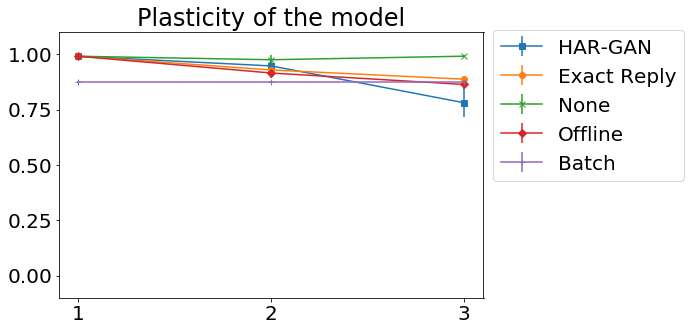

[1, 2, 3] mp-wgan [0.9904761904761905, 0.8486274796228107, 0.7255404705991708]
[1, 2, 3] exact [0.9904761904761905, 0.9382695035581283, 0.8825882061241306]
[1, 2, 3] none [0.9904761904761905, 0.4873863636363637, 0.33287980589772304]
[1, 2, 3] offline [0.9904761904761905, 0.932488899753331, 0.8734564022554847]
[1, 2, 3] batch [0.8734564022554847, 0.8734564022554847, 0.8734564022554847]


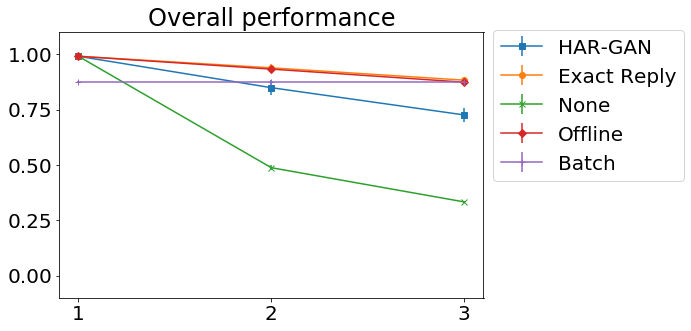

In [11]:
print("cGAN 5000")
selectModel("HouseA", "sg-cgan", 3)

print("mGAN 5000")
selectModel("HouseA", "mp-wgan", 3, mgan5000=True)
# selectModel("HouseA", "mp-gan", 3, mgan5000=True)

print("mGAN 1000")
selectModel("HouseA", "mp-wgan", 3, mgan5000=False)
# selectModel("HouseA", "mp-gan", 3, mgan5000=False)

[1, 2, 3, 4, 5] sg-cgan [0.9426666666666665, 0.767592708016621, 0.7547442738421, 0.7206784230262492, 0.673687595013682]
[1, 2, 3, 4, 5] exact [0.9524848484848485, 0.9239342632005677, 0.841751431539475, 0.8110071070234113, 0.7518124556602818]
[1, 2, 3, 4, 5] none [0.9524848484848485, 0.00953846153846154, 0.0, 0.0, 0.0]
[1, 2, 3, 4, 5] offline [0.9524848484848485, 0.8948382487078138, 0.826781569879396, 0.8077596913955609, 0.7549435872098916]
[1, 2, 3, 4, 5] batch [0.8743502560875542, 0.8743502560875542, 0.8743502560875542, 0.8743502560875542, 0.8743502560875542]


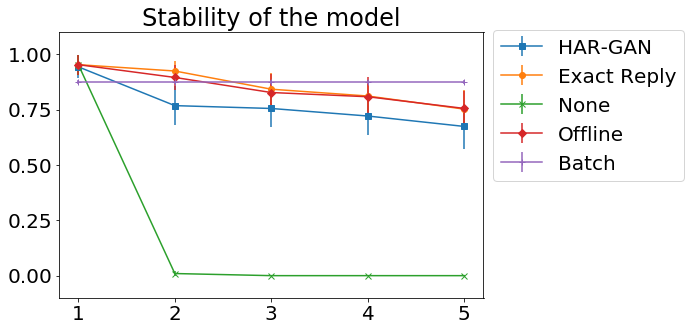

[1, 2, 3, 4, 5] sg-cgan [0.9426666666666665, 0.9105986463096437, 0.7037246753246753, 0.6738112546873417, 0.7601616028898638]
[1, 2, 3, 4, 5] exact [0.9524848484848485, 0.9238964771830457, 0.9024883116883116, 0.9845672342150603, 0.9728326492348233]
[1, 2, 3, 4, 5] none [0.9524848484848485, 0.9468766798418973, 0.9366943722943724, 0.9977136363636363, 0.9847803030303031]
[1, 2, 3, 4, 5] offline [0.9524848484848485, 0.9374146539920771, 0.8394978354978354, 0.9745953075909599, 0.9365021826000088]
[1, 2, 3, 4, 5] batch [0.8743502560875542, 0.8743502560875542, 0.8743502560875542, 0.8743502560875542, 0.8743502560875542]


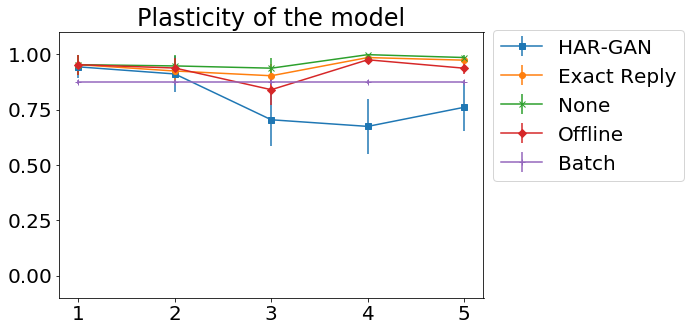

[1, 2, 3, 4, 5] sg-cgan [0.9426666666666665, 0.8390956771631325, 0.7726834183847986, 0.702036358392394, 0.6874172245184337]
[1, 2, 3, 4, 5] exact [0.9524848484848485, 0.9239153701918065, 0.8857727595356728, 0.863886243408983, 0.854672230463288]
[1, 2, 3, 4, 5] none [0.9524848484848485, 0.4782075706901794, 0.3122314574314574, 0.2526784090909091, 0.19841693017127798]
[1, 2, 3, 4, 5] offline [0.9524848484848485, 0.9161264513499454, 0.8725676483467601, 0.8695520407250855, 0.8743502560875542]
[1, 2, 3, 4, 5] batch [0.8743502560875542, 0.8743502560875542, 0.8743502560875542, 0.8743502560875542, 0.8743502560875542]


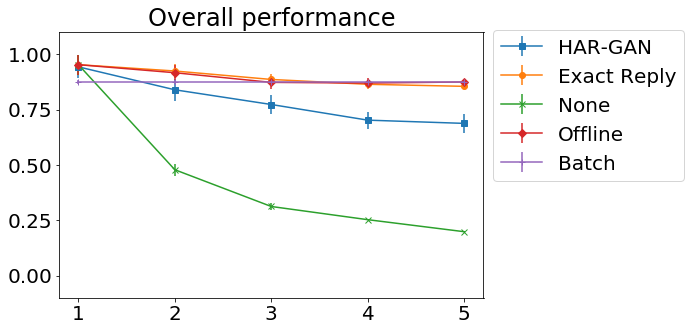

In [12]:
selectModel("CASAS", "sg-cgan", 3)

[1, 2, 3, 4, 5] sg-cgan [0.9866380952380952, 0.7787238095238095, 0.6667904761904762, 0.6106571428571429, 0.41768095238095243]
[1, 2, 3, 4, 5] exact [0.9804142857142859, 0.9750761904761905, 0.9715428571428572, 0.9618857142857141, 0.9587380952380953]
[1, 2, 3, 4, 5] none [0.9804142857142859, 0.18519999999999998, 0.005300000000000001, 0.0005, 0.0]
[1, 2, 3, 4, 5] offline [0.9823142857142857, 0.9231523809523811, 0.8255428571428572, 0.8636142857142858, 0.7826666666666666]
[1, 2, 3, 4, 5] batch [0.8009333333333333, 0.8009333333333333, 0.8009333333333333, 0.8009333333333333, 0.8009333333333333]


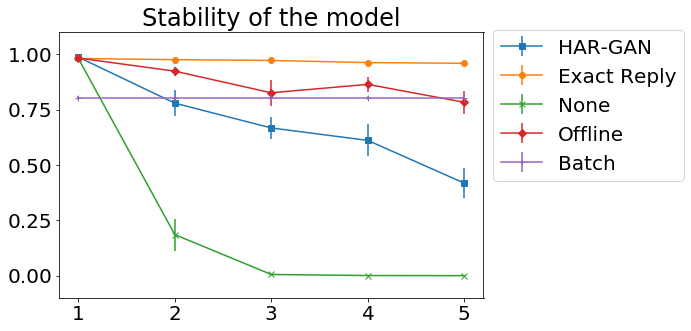

[1, 2, 3, 4, 5] sg-cgan [0.9866380952380952, 0.9603333333333334, 0.8977333333333334, 0.8678666666666667, 0.9278666666666666]
[1, 2, 3, 4, 5] exact [0.9804142857142859, 0.9117, 0.7128666666666666, 0.7210666666666666, 0.6591666666666667]
[1, 2, 3, 4, 5] none [0.9804142857142859, 0.9731, 0.9737, 0.9575000000000001, 0.9004666666666667]
[1, 2, 3, 4, 5] offline [0.9823142857142857, 0.9383000000000001, 0.9482000000000002, 0.8731333333333333, 0.7676000000000001]
[1, 2, 3, 4, 5] batch [0.8009333333333333, 0.8009333333333333, 0.8009333333333333, 0.8009333333333333, 0.8009333333333333]


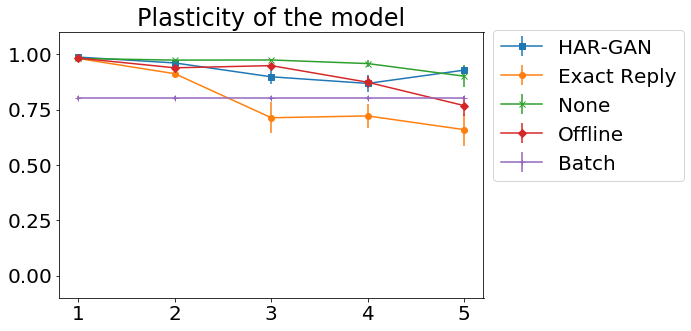

[1, 2, 3, 4, 5] sg-cgan [0.9866380952380952, 0.8695285714285715, 0.8308412698412699, 0.7875642857142857, 0.7079761904761904]
[1, 2, 3, 4, 5] exact [0.9804142857142859, 0.9433880952380951, 0.863547619047619, 0.8280630952380952, 0.793387619047619]
[1, 2, 3, 4, 5] none [0.9804142857142859, 0.57915, 0.42385555555555554, 0.32049166666666673, 0.2763466666666667]
[1, 2, 3, 4, 5] offline [0.9823142857142857, 0.9307261904761905, 0.899447619047619, 0.8684619047619048, 0.8009333333333333]
[1, 2, 3, 4, 5] batch [0.8009333333333333, 0.8009333333333333, 0.8009333333333333, 0.8009333333333333, 0.8009333333333333]


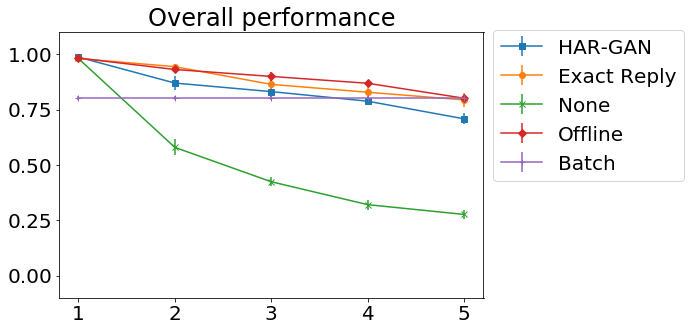

In [13]:
selectModel("PAMAP", "sg-cgan", 3)

cGAN 5000
[1, 2, 3, 4, 5] sg-cgan [0.9468333333333334, 0.5119999999999999, 0.3846666666666667, 0.2593333333333333, 0.18933333333333333]
[1, 2, 3, 4, 5] exact [0.9376666666666666, 0.9351666666666667, 0.9351666666666667, 0.9331666666666667, 0.9305]
[1, 2, 3, 4, 5] none [0.9376666666666666, 0.09, 0.0, 0.0, 0.0]
[1, 2, 3, 4, 5] offline [0.9376666666666666, 0.8004999999999999, 0.7486666666666666, 0.6383333333333333, 0.4708333333333334]
[1, 2, 3, 4, 5] batch [0.6781000000000001, 0.6781000000000001, 0.6781000000000001, 0.6781000000000001, 0.6781000000000001]


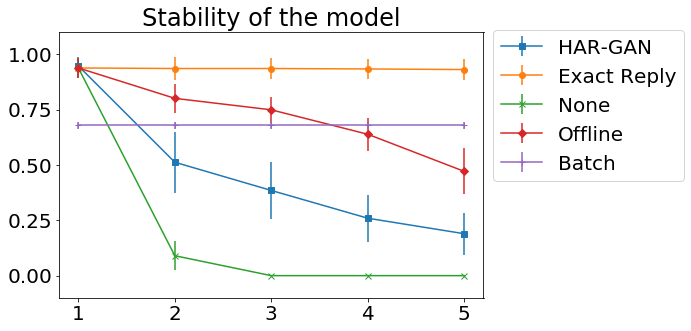

[1, 2, 3, 4, 5] sg-cgan [0.9468333333333334, 0.8333333333333334, 0.672, 0.8606666666666666, 0.8091666666666665]
[1, 2, 3, 4, 5] exact [0.9376666666666666, 0.5566666666666668, 0.36966666666666664, 0.17133333333333334, 0.4493333333333333]
[1, 2, 3, 4, 5] none [0.9376666666666666, 0.8506666666666668, 0.7381666666666666, 0.9533333333333331, 0.8486666666666667]
[1, 2, 3, 4, 5] offline [0.9376666666666666, 0.884, 0.716, 0.7345, 0.8101666666666667]
[1, 2, 3, 4, 5] batch [0.6781000000000001, 0.6781000000000001, 0.6781000000000001, 0.6781000000000001, 0.6781000000000001]


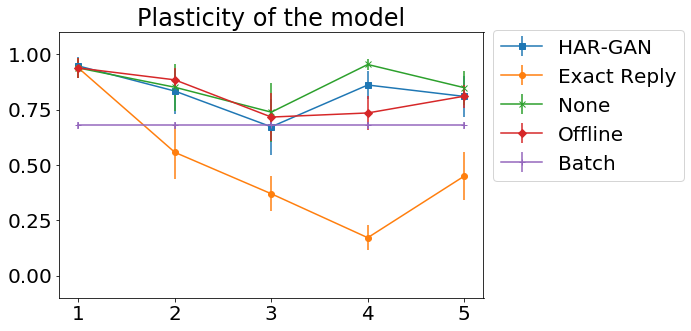

[1, 2, 3, 4, 5] sg-cgan [0.9468333333333334, 0.6726666666666667, 0.5618333333333334, 0.533, 0.5124000000000001]
[1, 2, 3, 4, 5] exact [0.9376666666666666, 0.7459166666666668, 0.6189444444444444, 0.5015833333333333, 0.48806666666666665]
[1, 2, 3, 4, 5] none [0.9376666666666666, 0.4703333333333333, 0.30877777777777776, 0.284625, 0.2271]
[1, 2, 3, 4, 5] offline [0.9376666666666666, 0.8422499999999999, 0.7397777777777778, 0.6988750000000001, 0.6781000000000001]
[1, 2, 3, 4, 5] batch [0.6781000000000001, 0.6781000000000001, 0.6781000000000001, 0.6781000000000001, 0.6781000000000001]


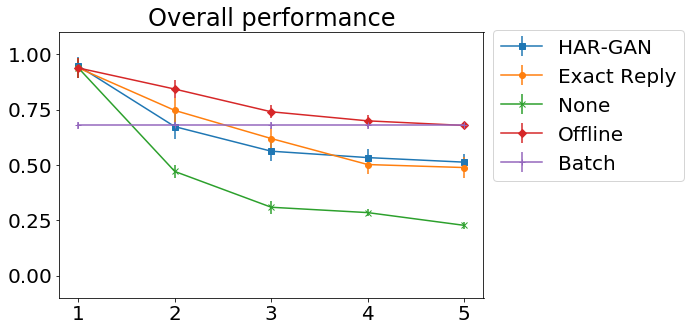

mGAN 5000
[1, 2, 3, 4, 5] mp-gan [0.9395, 0.6395000000000001, 0.4246666666666667, 0.41566666666666663, 0.3745]
[1, 2, 3, 4, 5] exact [0.9376666666666666, 0.9351666666666667, 0.9351666666666667, 0.9331666666666667, 0.9305]
[1, 2, 3, 4, 5] none [0.9376666666666666, 0.09, 0.0, 0.0, 0.0]
[1, 2, 3, 4, 5] offline [0.9376666666666666, 0.8004999999999999, 0.7486666666666666, 0.6383333333333333, 0.4708333333333334]
[1, 2, 3, 4, 5] batch [0.6781000000000001, 0.6781000000000001, 0.6781000000000001, 0.6781000000000001, 0.6781000000000001]


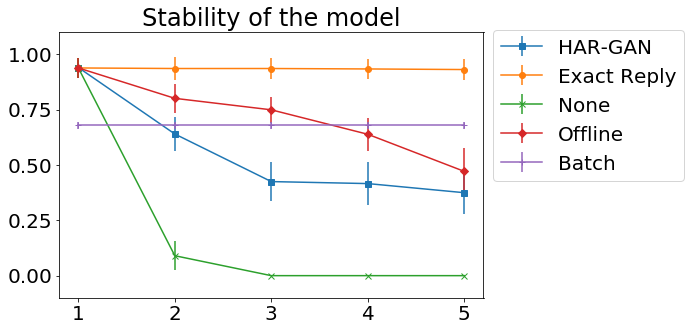

[1, 2, 3, 4, 5] mp-gan [0.9395, 0.8326666666666668, 0.6608333333333333, 0.7801666666666668, 0.761]
[1, 2, 3, 4, 5] exact [0.9376666666666666, 0.5566666666666668, 0.36966666666666664, 0.17133333333333334, 0.4493333333333333]
[1, 2, 3, 4, 5] none [0.9376666666666666, 0.8506666666666668, 0.7381666666666666, 0.9533333333333331, 0.8486666666666667]
[1, 2, 3, 4, 5] offline [0.9376666666666666, 0.884, 0.716, 0.7345, 0.8101666666666667]
[1, 2, 3, 4, 5] batch [0.6781000000000001, 0.6781000000000001, 0.6781000000000001, 0.6781000000000001, 0.6781000000000001]


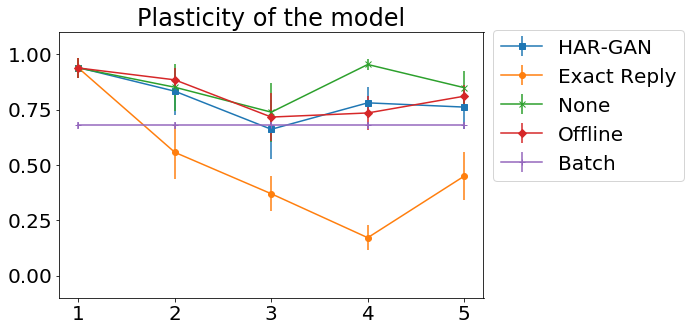

[1, 2, 3, 4, 5] mp-gan [0.9395, 0.7360833333333334, 0.5035000000000001, 0.49187499999999995, 0.4531666666666667]
[1, 2, 3, 4, 5] exact [0.9376666666666666, 0.7459166666666668, 0.6189444444444444, 0.5015833333333333, 0.48806666666666665]
[1, 2, 3, 4, 5] none [0.9376666666666666, 0.4703333333333333, 0.30877777777777776, 0.284625, 0.2271]
[1, 2, 3, 4, 5] offline [0.9376666666666666, 0.8422499999999999, 0.7397777777777778, 0.6988750000000001, 0.6781000000000001]
[1, 2, 3, 4, 5] batch [0.6781000000000001, 0.6781000000000001, 0.6781000000000001, 0.6781000000000001, 0.6781000000000001]


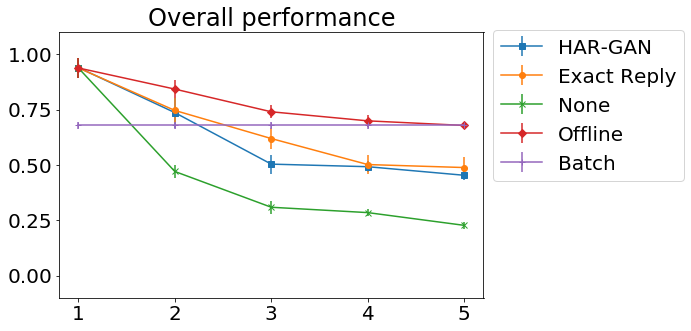

mGAN 1000
[1, 2, 3, 4, 5] mp-gan [0.9351666666666667, 0.477, 0.15066666666666667, 0.066, 0.02733333333333333]
[1, 2, 3, 4, 5] exact [0.9376666666666666, 0.9351666666666667, 0.9351666666666667, 0.9331666666666667, 0.9305]
[1, 2, 3, 4, 5] none [0.9376666666666666, 0.09, 0.0, 0.0, 0.0]
[1, 2, 3, 4, 5] offline [0.9376666666666666, 0.8004999999999999, 0.7486666666666666, 0.6383333333333333, 0.4708333333333334]
[1, 2, 3, 4, 5] batch [0.6781000000000001, 0.6781000000000001, 0.6781000000000001, 0.6781000000000001, 0.6781000000000001]


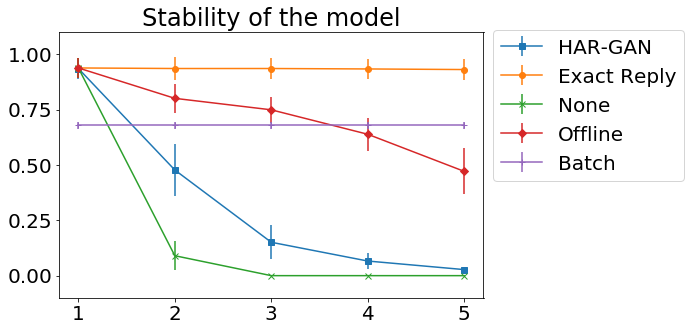

[1, 2, 3, 4, 5] mp-gan [0.9351666666666667, 0.8306666666666667, 0.7561666666666668, 0.8773333333333333, 0.7456666666666666]
[1, 2, 3, 4, 5] exact [0.9376666666666666, 0.5566666666666668, 0.36966666666666664, 0.17133333333333334, 0.4493333333333333]
[1, 2, 3, 4, 5] none [0.9376666666666666, 0.8506666666666668, 0.7381666666666666, 0.9533333333333331, 0.8486666666666667]
[1, 2, 3, 4, 5] offline [0.9376666666666666, 0.884, 0.716, 0.7345, 0.8101666666666667]
[1, 2, 3, 4, 5] batch [0.6781000000000001, 0.6781000000000001, 0.6781000000000001, 0.6781000000000001, 0.6781000000000001]


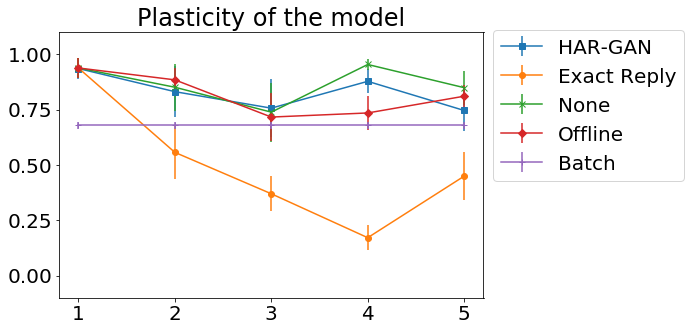

[1, 2, 3, 4, 5] mp-gan [0.9351666666666667, 0.6538333333333333, 0.5299444444444446, 0.47545833333333337, 0.4613666666666666]
[1, 2, 3, 4, 5] exact [0.9376666666666666, 0.7459166666666668, 0.6189444444444444, 0.5015833333333333, 0.48806666666666665]
[1, 2, 3, 4, 5] none [0.9376666666666666, 0.4703333333333333, 0.30877777777777776, 0.284625, 0.2271]
[1, 2, 3, 4, 5] offline [0.9376666666666666, 0.8422499999999999, 0.7397777777777778, 0.6988750000000001, 0.6781000000000001]
[1, 2, 3, 4, 5] batch [0.6781000000000001, 0.6781000000000001, 0.6781000000000001, 0.6781000000000001, 0.6781000000000001]


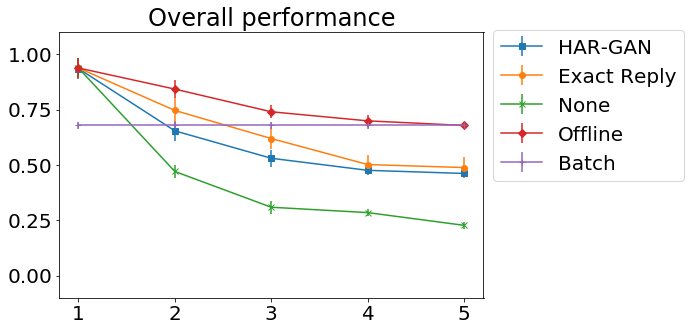

In [14]:
print("cGAN 5000")
selectModel("DSADS", "sg-cgan", 3)

print("mGAN 5000")
# selectModel("DSADS", "mp-wgan", 3, mgan5000=True)
selectModel("DSADS", "mp-gan", 3, mgan5000=True)

print("mGAN 1000")
# selectModel("DSADS", "mp-wgan", 3, mgan5000=False)
selectModel("DSADS", "mp-gan", 3, mgan5000=False)

[1, 2, 3] mp-gan [0.9904761904761905, 0.8515877939265035, 0.8089757822822339]
[1, 2, 3] mp-wgan [0.9904761904761905, 0.8984447004608296, 0.8825800006445167]
[1, 2, 3] sg-cgan [0.9904761904761905, 0.8582565284178185, 0.8208007852362691]
[1, 2, 3] sg-cwgan [0.9904761904761905, 0.7057928630509276, 0.5636623591462301]


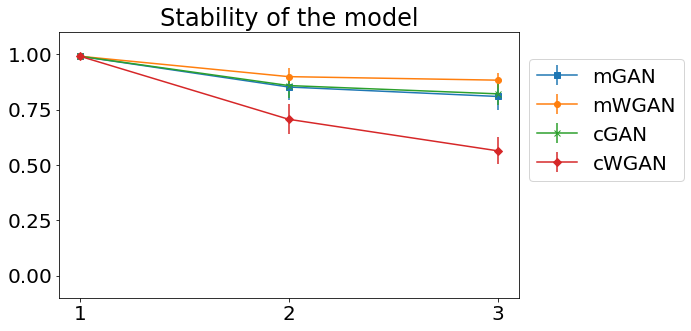

[1, 2, 3] mp-gan [0.9904761904761905, 0.9094755739450138, 0.7714976915521473]
[1, 2, 3] mp-wgan [0.9904761904761905, 0.9188719670256174, 0.7760967234489794]
[1, 2, 3] sg-cgan [0.9904761904761905, 0.9236272117808622, 0.7700596827584509]
[1, 2, 3] sg-cwgan [0.9904761904761905, 0.9344774142100117, 0.8694477965411391]


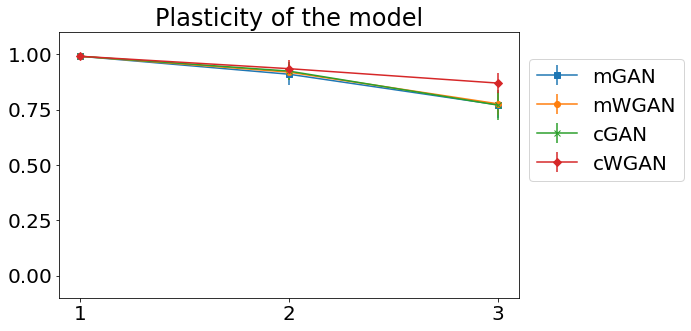

[1, 2, 3] mp-gan [0.9904761904761905, 0.8805316839357588, 0.7951380137300197]
[1, 2, 3] mp-wgan [0.9904761904761905, 0.9086583337432235, 0.8417282803490945]
[1, 2, 3] sg-cgan [0.9904761904761905, 0.8909418700993404, 0.7810491639832751]
[1, 2, 3] sg-cwgan [0.9904761904761905, 0.8201351386304697, 0.7315162131293873]


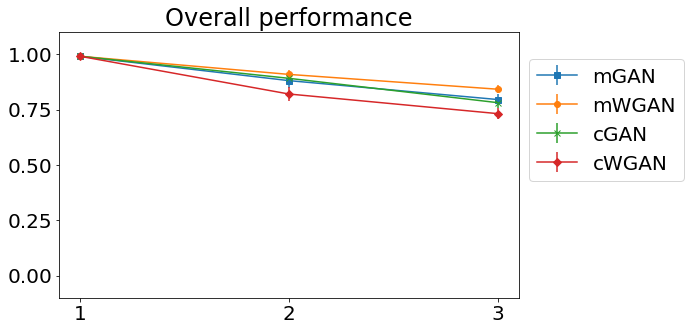

In [11]:
import copy

(stability, plasticity, overallAcc) = copy.deepcopy(all_values["HouseA"])

(_stability, _plasticity, _overallAcc) = _all_values["HouseA"]

for model in ["mp-gan", "mp-wgan"]:
    stability[3][model] = _stability[0][model]
    plasticity[3][model] = _plasticity[0][model]
    overallAcc[3][model] = _overallAcc[0][model]


models = ["mp-gan", "mp-wgan", "sg-cgan", "sg-cwgan"]
legends = ["mGAN", "mWGAN", "cGAN", "cWGAN"]

# x = [1,2,3,4,5]
# if db=="HouseA":
x = [1,2,3]

plotline(stability[3], "Stability of the model", x=x, models=models, legends=legends)
plotline(plasticity[3], "Plasticity of the model", x=x, models=models, legends=legends)
plotline(overallAcc[3], "Overall performance", x=x, models=models, legends=legends)


[1, 2, 3, 4, 5] mp-gan [0.9395, 0.6395000000000001, 0.4246666666666667, 0.41566666666666663, 0.3745]
[1, 2, 3, 4, 5] mp-wgan [0.9385, 0.25766666666666665, 0.1653333333333333, 0.11183333333333334, 0.067]
[1, 2, 3, 4, 5] sg-cgan [0.9468333333333334, 0.5119999999999999, 0.3846666666666667, 0.2593333333333333, 0.18933333333333333]
[1, 2, 3, 4, 5] sg-cwgan [0.9416666666666668, 0.38983333333333337, 0.086, 0.0, 0.0]


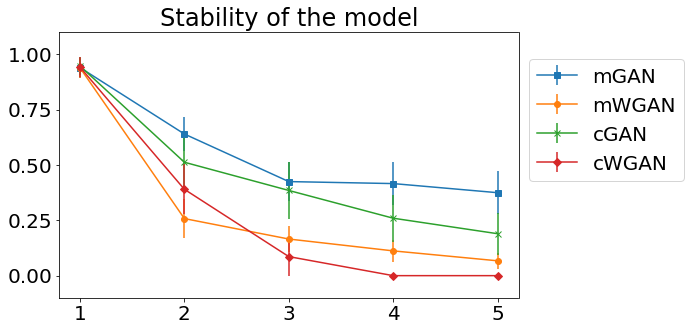

[1, 2, 3, 4, 5] mp-gan [0.9395, 0.8326666666666668, 0.6608333333333333, 0.7801666666666668, 0.761]
[1, 2, 3, 4, 5] mp-wgan [0.9385, 0.8480000000000001, 0.7455, 0.9453333333333334, 0.794]
[1, 2, 3, 4, 5] sg-cgan [0.9468333333333334, 0.8333333333333334, 0.672, 0.8606666666666666, 0.8091666666666665]
[1, 2, 3, 4, 5] sg-cwgan [0.9416666666666668, 0.8620000000000001, 0.7975, 0.9446666666666668, 0.8103333333333333]


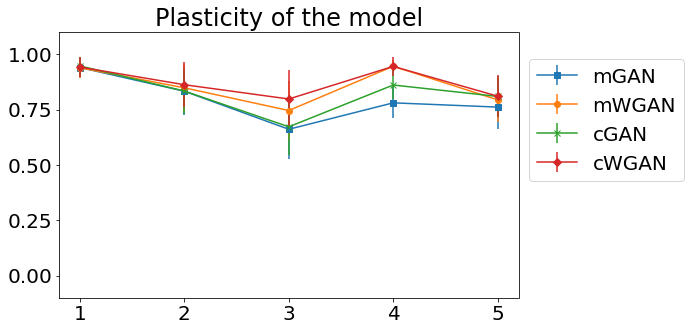

[1, 2, 3, 4, 5] mp-gan [0.9395, 0.7360833333333334, 0.5035000000000001, 0.49187499999999995, 0.4531666666666667]
[1, 2, 3, 4, 5] mp-wgan [0.9385, 0.5528333333333333, 0.39299999999999996, 0.36991666666666667, 0.3032]
[1, 2, 3, 4, 5] sg-cgan [0.9468333333333334, 0.6726666666666667, 0.5618333333333334, 0.533, 0.5124000000000001]
[1, 2, 3, 4, 5] sg-cwgan [0.9416666666666668, 0.6259166666666666, 0.4031666666666666, 0.33408333333333334, 0.2737]


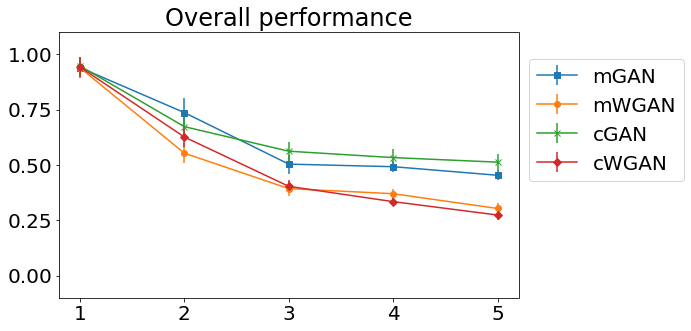

In [13]:
import copy

(stability, plasticity, overallAcc) = copy.deepcopy(all_values["DSADS"])

(_stability, _plasticity, _overallAcc) = _all_values["DSADS"]

for model in ["mp-gan", "mp-wgan"]:
    stability[3][model] = _stability[0][model]
    plasticity[3][model] = _plasticity[0][model]
    overallAcc[3][model] = _overallAcc[0][model]


models = ["mp-gan", "mp-wgan", "sg-cgan", "sg-cwgan"]
legends = ["mGAN", "mWGAN", "cGAN", "cWGAN"]

x = [1,2,3,4,5]

plotline(stability[3], "Stability of the model", x=x, models=models, legends=legends)
plotline(plasticity[3], "Plasticity of the model", x=x, models=models, legends=legends)
plotline(overallAcc[3], "Overall performance", x=x, models=models, legends=legends)
